# Optimizing for Eigenfluids Initial Parameters
## Given final velocity field only

In this optimization scenario, given a final velocity field $v_{target}: [0,\pi]\times[0,\pi] \to \mathbb{R}^2$, we are looking for initial base coefficients $\omega_0$, such that after time $t$, the velocity field reconstructed from the resulting coefficients $\omega_t$ will be exactly $v_{target}$, i.e.:

$$
\arg\min_{\omega} \Big|\text{reconstruct}(\mathcal{P}^{t}(\omega)) - v_{target} \Big|_2^2,
$$

where $\mathcal{P}^t(\omega) = \underbrace{\mathcal{P} \circ \mathcal{P} \dots \circ \mathcal{P}(\omega)}_{t \text{ times}}$ is the physical simulation of base coefficients $\omega$ (in the reduced dimension) $t$ times.

In [1]:
from phi.torch.flow import *
import matplotlib.pyplot as plt

from src.eigenfluid import Eigenfluid

# Helper functions for visualization
from src.visu import *

import time

In [2]:
# Number of basis fields
N = 4**2 
# Domain sizes
DOMAIN = Box(x=math.PI, y=math.PI)
SAMPLING_SIZE = 32

start_time = time.time()
eigenfluid = Eigenfluid(N, DOMAIN, SAMPLING_SIZE)
end_time = time.time()
print("Eigenfluid initialized in {} seconds".format(end_time-start_time))

Eigenfluid initialized in 6.037893056869507 seconds


# Reference Simulations

In [3]:
velocity = eigenfluid.reconstruct_velocity()

trajectory_v = [velocity]
trajectory_curl = [field.curl(velocity)]

#Increase this for harder scenarios
STEPS = 100
DT = 0.2

w_0 = eigenfluid.w

start_time = time.time()
for i in range(STEPS):
    # For grid-based simulation:
    #velocity = advect.semi_lagrangian(velocity, velocity, dt=DT)
    #velocity, _ = fluid.make_incompressible(velocity)
    eigenfluid.w = eigenfluid.step_w_euler(eigenfluid.w, DT)
    
    curr_vel = eigenfluid.reconstruct_velocity()
    trajectory_v.append(curr_vel)
    trajectory_curl.append(field.curl(curr_vel))
end_time = time.time()
print("Simulation finished in {} seconds".format(end_time-start_time))

trajectory_v_ref = math.stack(trajectory_v, batch('time'))
trajectory_curl_ref = math.stack(trajectory_curl, batch('time'))

v_target = eigenfluid.reconstruct_velocity()

Simulation finished in 4.151131868362427 seconds


# Gradients from Eigenfluid simulation

In [4]:
def loss_function(w):
    eigenfluid.w = w
    #velocities = [eigenfluid.reconstruct_velocity()]
    for t in range(STEPS):
        eigenfluid.w = eigenfluid.step_w_euler(eigenfluid.w, DT)
        #velocities.append(eigenfluid.reconstruct_velocity())
    loss = field.l2_loss(eigenfluid.reconstruct_velocity() - v_target)
    return loss#, velocities

gradient_function = math.gradient(loss_function)

loss, grad = gradient_function(w_0)
print("This loss should be zero: {}".format(loss))

This loss should be zero: 0.0


# Optimize for Unknown initial w
Now we would like to find an initial w vector such that it lines up with the target simulation after STEPS number of iterations.

In [17]:
# Initialize w to some value for optimization (random or 0)
#w_init = math.zeros_like(eigenfluid.w)
w_init = math.random_normal(eigenfluid.w.shape)

# first gradient
loss, grad = gradient_function(w_init)
print("Initial Loss of Optimization: {}".format(loss))

Initial Loss of Optimization: 969.38824


## Optimization

Some manual tuning of the learning parameter (LR) might be necessary, depending on the random initial value.

In [34]:
LR = 0.00005

w_optim = w_init
grads = [grad[-1]]
for optim_step in range(101):
    loss, grad = gradient_function(w_optim)
    if optim_step%20 == 0 or optim_step < 5:
        print("Optimization step %d, loss: %f" % (optim_step, loss))
    grads.append( grad[0] )
    
    w_optim = w_optim - LR * grads[-1]

Optimization step 0, loss: 969.388245
Optimization step 1, loss: 1002.251831
Optimization step 2, loss: 977.460205
Optimization step 3, loss: 978.684509
Optimization step 4, loss: 957.371399
Optimization step 20, loss: 794.103027
Optimization step 40, loss: 655.978760
Optimization step 60, loss: 550.185913
Optimization step 80, loss: 484.110535
Optimization step 100, loss: 462.594360


At this point, we probably need to run some more epochs (depending on the random initialization). Also feel free to tweak the epoch number and learning parameter once the loss gets closer to zero.

In [35]:
LR = 0.0005

grads = [grad[-1]]
for optim_step in range(101,501):
    loss, grad = gradient_function(w_optim)
    if optim_step%20 == 0 or optim_step < 5:
        print("Optimization step %d, loss: %f" % (optim_step, loss))
    grads.append( grad[0] )
    if optim_step == 200:
        LR /= 10
    
    w_optim = w_optim - LR * grads[-1]

Optimization step 120, loss: 87.435745
Optimization step 140, loss: 25.075909
Optimization step 160, loss: 2.945851
Optimization step 180, loss: 1.846121
Optimization step 200, loss: 1.574832
Optimization step 220, loss: 0.683879
Optimization step 240, loss: 0.648399
Optimization step 260, loss: 0.625649
Optimization step 280, loss: 0.609948
Optimization step 300, loss: 0.598237
Optimization step 320, loss: 0.588865
Optimization step 340, loss: 0.580948
Optimization step 360, loss: 0.573990
Optimization step 380, loss: 0.567710
Optimization step 400, loss: 0.561940
Optimization step 420, loss: 0.556569
Optimization step 440, loss: 0.551524
Optimization step 460, loss: 0.546754
Optimization step 480, loss: 0.542219
Optimization step 500, loss: 0.537893


<Figure size 864x360 with 2 Axes>

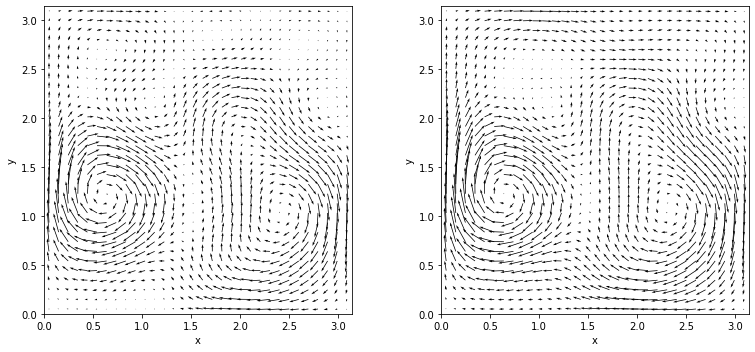

In [36]:
#plot({"Target Velocity": v_target, "Optimized Velocity": eigenfluid.reconstruct_velocity()})
plot([v_target, eigenfluid.reconstruct_velocity()])

In [37]:
list16 = [i for i in range(1,17)]

<BarContainer object of 16 artists>

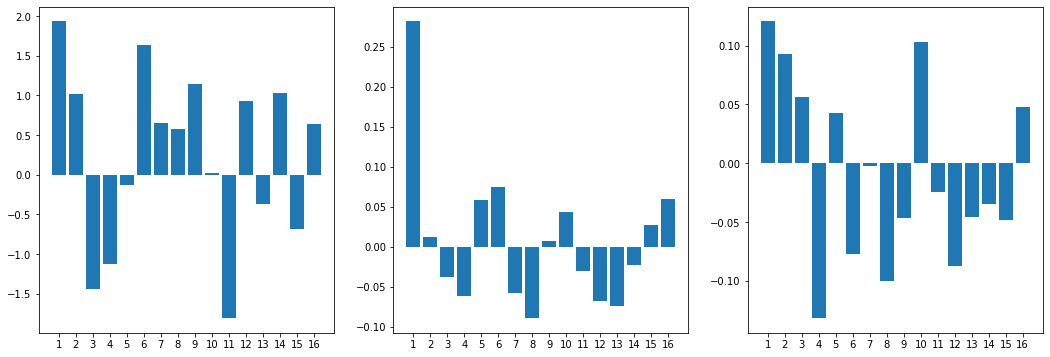

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))#, constrained_layout=True)


#axs[0].set_title("Randomly initialized coefficients")
axs[0].bar(list16, w_init.numpy(), tick_label=list16)

#axs[1].set_title("Optimized coefficients")
axs[1].bar(list16, w_optim.numpy(), tick_label=list16)

#axs[2].set_title("Target coefficients\n(Unknown during optimization)")
axs[2].bar(list16, w_0.numpy(), tick_label=list16)